In [1]:
! pip install torchvision torch matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 85.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 84.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 17.3 MB/s eta 0:00:00


In [2]:
import torchvision
import torch

In [3]:
from torchvision.transforms import v2

transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Lambda(lambd=lambda img: img / 255)
])


train_dataset = torchvision.datasets.MNIST("dataset", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST("dataset", train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 158601777.09it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30080877.53it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw


100%|██████████| 1648877/1648877 [00:00<00:00, 123663681.66it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4043839.69it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [4]:
import torch.nn as nn
import torch.nn.functional as F

class SubSampling(nn.Module):
    def __init__(self, in_shape, out_shape):
        super().__init__()
        assert len(in_shape) == 3
        assert len(out_shape) == 3
        assert in_shape[0] == out_shape[0]
        assert in_shape[1] == in_shape[2]
        assert out_shape[1] == out_shape[2]
        assert in_shape[1] // 2 == out_shape[1]

        C = out_shape[0]
        self.alpha = nn.Parameter(torch.ones((C, 1, 1)), requires_grad=True)
        self.beta = nn.Parameter(torch.zeros((C, 1, 1)), requires_grad=True)

    def forward(self, x):
        h = F.avg_pool2d(x, kernel_size=2, divisor_override=1)
        return self.alpha * h + self.beta

class LeNetTanh(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 1.7159 * F.tanh(2/3 * x)

class SparseConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        w = torch.randn((out_channels, in_channels, kernel_size, kernel_size))
        mask = torch.tensor([
            [True, True, True, False, False, False],
            [False, True, True, True, False, False],
            [False, False, True, True, True, False],
            [False, False, False, True, True, True],
            [True, False, False, False, True, True],
            [True, True, False, False, False, True],
            [True, True, True, True, False, False],
            [False, True, True, True, True, False],
            [False, False, True, True, True, True],
            [True, False, False, True, True, True],
            [True, True, False, False, True, True],
            [True, True, True, False, False, True],
            [True, True, False, True, True, False],
            [False, True, True, False, True, True],
            [True, False, True, True, False, True],
            [True, True, True, True, True, True],
        ])
        w[mask, :, :] = 0

        def hook(module, grad_input, grad_output):
            module.w.grad.data[mask, :, :] = 0
        
        self.register_full_backward_hook(hook)
        
        self.w = nn.Parameter(w, requires_grad=True)
        self.b = nn.Parameter(torch.zeros(out_channels), requires_grad=True)

    def forward(self, x):
        return F.conv2d(x, self.w, self.b)

class RBF(nn.Module):
    def __init__(self):
        super().__init__()
        _zero = torch.tensor([
            [0,1,1,1,1,1,0],
            [0,0,0,0,0,0,0],
            [0,0,1,1,1,0,0],
            [0,1,1,0,1,1,0],
            [1,1,0,0,0,1,1],
            [1,1,0,0,0,1,1],
            [1,1,0,0,0,1,1],
            [1,1,0,0,0,1,1],
            [0,1,1,0,1,1,0],
            [0,0,1,1,1,0,0],
            [0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0],
        ])
        _zero = torch.where(_zero == 0, -1, _zero).flatten()

        _one = torch.tensor([
            [0,0,0,1,1,0,0],
            [0,0,1,1,1,0,0],
            [0,1,1,1,1,0,0],
            [0,0,0,1,1,0,0],
            [0,0,0,1,1,0,0],
            [0,0,0,1,1,0,0],
            [0,0,0,1,1,0,0],
            [0,0,0,1,1,0,0],
            [0,0,0,1,1,0,0],
            [0,1,1,1,1,1,1],
            [0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0],
        ])
        _one = torch.where(_one == 0, -1, _one).flatten()

        _two = torch.tensor([
            [0,1,1,1,1,1,0],
            [0,0,0,0,0,0,0],
            [0,1,1,1,1,1,0],
            [1,1,0,0,0,1,1],
            [1,0,0,0,0,1,1],
            [0,0,0,0,1,1,0],
            [0,0,1,1,1,0,0],
            [0,1,1,0,0,0,0],
            [1,1,0,0,0,0,0],
            [1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0],
        ])
        _two = torch.where(_two == 0, -1, _two).flatten()

        _three = torch.tensor([
            [1,1,1,1,1,1,1],
            [0,0,0,0,0,1,1],
            [0,0,0,0,1,1,0],
            [0,0,0,1,1,0,0],
            [0,0,1,1,1,1,0],
            [0,0,0,0,0,1,1],
            [0,0,0,0,0,1,1],
            [0,0,0,0,0,1,1],
            [1,0,0,0,0,1,1],
            [0,1,1,1,1,1,0],
            [0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0],
        ])
        _three = torch.where(_three == 0, -1, _three).flatten()

        _four = torch.tensor([
            [0,1,1,1,1,1,0],
            [0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0],
            [0,1,1,0,0,1,1],
            [0,1,1,0,0,1,1],
            [1,1,1,0,0,1,1],
            [1,1,0,0,0,1,1],
            [1,1,0,0,0,1,1],
            [1,1,0,0,1,1,1],
            [0,1,1,1,1,1,1],
            [0,0,0,0,0,1,1],
            [0,0,0,0,0,1,1],
        ])
        _four = torch.where(_four == 0, -1, _four).flatten()

        _five = torch.tensor([
            [0,1,1,1,1,1,0],
            [0,0,0,0,0,0,0],
            [1,1,1,1,1,1,1],
            [1,1,0,0,0,0,0],
            [1,1,0,0,0,0,0],
            [0,1,1,1,1,0,0],
            [0,0,1,1,1,1,0],
            [0,0,0,0,0,1,1],
            [1,1,0,0,0,1,1],
            [0,1,1,1,1,1,0],
            [0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0],
        ])
        _five = torch.where(_five == 0, -1, _five).flatten()

        _six = torch.tensor([
            [0,0,1,1,1,1,0],
            [0,1,1,0,0,0,0],
            [1,1,0,0,0,0,0],
            [1,1,0,0,0,0,0],
            [1,1,1,1,1,1,0],
            [1,1,1,0,0,1,1],
            [1,1,0,0,0,1,1],
            [1,1,0,0,0,1,1],
            [1,1,1,0,0,1,1],
            [0,1,1,1,1,1,0],
            [0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0],
        ])
        _six = torch.where(_six == 0, -1, _six).flatten()

        _seven = torch.tensor([
            [1,1,1,1,1,1,1],
            [0,0,0,0,0,1,1],
            [0,0,0,0,0,1,1],
            [0,0,0,0,1,1,0],
            [0,0,0,1,1,0,0],
            [0,0,0,1,1,0,0],
            [0,0,1,1,0,0,0],
            [0,0,1,1,0,0,0],
            [0,0,1,1,0,0,0],
            [0,0,1,1,0,0,0],
            [0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0],
        ])
        _seven = torch.where(_seven == 0, -1, _seven).flatten()

        _eight = torch.tensor([
            [0,1,1,1,1,1,0],
            [1,1,0,0,0,1,1],
            [1,1,0,0,0,1,1],
            [1,1,0,0,0,1,1],
            [0,1,1,1,1,1,0],
            [1,1,0,0,0,1,1],
            [1,1,0,0,0,1,1],
            [1,1,0,0,0,1,1],
            [1,1,0,0,0,1,1],
            [0,1,1,1,1,1,0],
            [0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0],
        ])

        _eight = torch.where(_eight == 0, -1, _eight).flatten()
        _nine = torch.tensor([
            [0,1,1,1,1,1,0],
            [1,1,0,0,1,1,1],
            [1,1,0,0,0,1,1],
            [1,1,0,0,0,1,1],
            [1,1,0,0,1,1,1],
            [0,1,1,1,1,1,1],
            [0,0,0,0,0,1,1],
            [0,0,0,0,0,1,1],
            [0,0,0,0,1,1,0],
            [1,1,1,1,1,0,0],
            [0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0],
        ])
        _nine = torch.where(_nine == 0, -1, _nine).flatten()

        self.W = nn.Parameter(torch.stack((_zero, _one, _two, _three, _four, _five, _six, _seven, _eight, _nine), dim=0).to(dtype=torch.float32), requires_grad=True)
        # self.W = torch.stack((_zero, _one, _two, _three, _four, _five, _six, _seven, _eight, _nine), dim=0)

    def forward(self, x):
        x = x.unsqueeze(dim=1)
        return (x - self.W).pow(2).sum(dim=2)

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            LeNetTanh(),
            SubSampling(in_shape=(6, 28, 28), out_shape=(6, 14, 14)),
            LeNetTanh(),
            # todo the next layer should be sparse, not all 6 in_channels are connected with the 16 out_channels
            SparseConv2D(in_channels=6, out_channels=16, kernel_size=5),
            LeNetTanh(),
            SubSampling(in_shape=(16, 10, 10), out_shape=(16, 5, 5)),
            LeNetTanh(),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5),
            LeNetTanh(),
            nn.Flatten(),
            nn.Linear(in_features=120, out_features=84),
            LeNetTanh(),
            RBF(),
        )
    
    def forward(self, x):
        return self.layers(x)

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [42]:
model = LeNet5().to(device)

In [40]:
def loss_fn(X, y, model):
    j = 2
    pred = model(X)
    # mask = torch.ones((y.numel(), 10), dtype=torch.bool)
    # mask[torch.arange(X.size(0)), y] = False

    correct = pred[torch.arange(y.numel()), y]
    # incorrect = torch.log(torch.exp(torch.tensor(-j)) + torch.exp(-pred[mask].view(X.size(0), -1)).sum(dim=1))
    second_term = torch.log(torch.exp(torch.tensor(-j)) + torch.exp(-pred.view(X.size(0), -1)).sum(dim=1))

    return (correct + second_term).mean()

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        loss = loss_fn(X, y, model)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            correct += (pred.argmin(1) == y).type(torch.float).sum().item()
    correct /= size

    return 100*(1-correct)
    # print(f"Test Error: \n Error: {(100*(1-correct)):>0.1f}%")

In [43]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=1)

train_errors = []
test_errors = []
optimizer = torch.optim.AdamW(model.parameters())
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1, gamma=0.9)
for epoch in range(20):
    # if epoch < 10:
    #     lr = 1e-3
    # else:
    #     lr = 1e-4
    # mu = 0.9
    
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)    
    print(f"{epoch=}")
    train(train_dataloader, model, loss_fn, optimizer)
    # scheduler.step()
    
    train_error = test(train_dataloader, model)
    train_errors.append(train_error)
    test_error = test(test_dataloader, model)
    test_errors.append(test_error)
    print(f"{train_error=} {test_error=}")


epoch=0
train_error=3.376666666666661 test_error=3.3399999999999985
epoch=1
train_error=2.5466666666666637 test_error=2.7100000000000013
epoch=2
train_error=2.076666666666671 test_error=2.3800000000000043
epoch=3
train_error=1.6449999999999965 test_error=1.9900000000000029
epoch=4
train_error=1.3966666666666683 test_error=1.6900000000000026
epoch=5
train_error=1.244999999999996 test_error=1.6299999999999981
epoch=6
train_error=1.165000000000005 test_error=1.739999999999997
epoch=7
train_error=1.1533333333333284 test_error=1.6599999999999948
epoch=8
train_error=1.100000000000001 test_error=1.7800000000000038
epoch=9
train_error=0.9483333333333288 test_error=1.6199999999999992
epoch=10
train_error=1.4966666666666684 test_error=1.9199999999999995
epoch=11
train_error=0.9683333333333377 test_error=1.649999999999996
epoch=12
train_error=0.8266666666666644 test_error=1.649999999999996
epoch=13
train_error=0.6233333333333313 test_error=1.4000000000000012
epoch=14
train_error=0.556666666666672

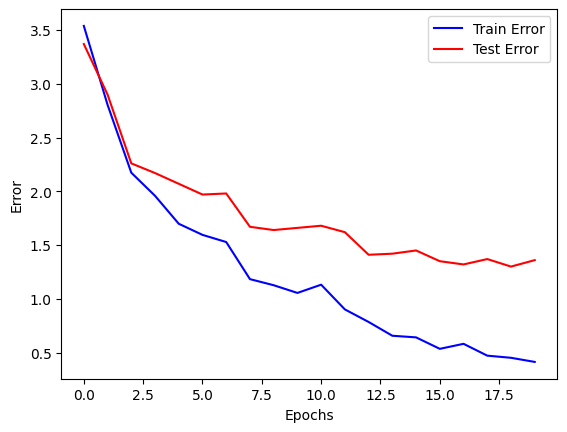

In [29]:
import matplotlib.pyplot as plt

x = [i for i in range(20)]
plt.plot(x, torch.tensor(train_errors), label="Train Error", color="blue")
plt.plot(x, torch.tensor(test_errors), label="Test Error", color="red")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend() 
plt.show()

In [19]:
test_dataloader = DataLoader(test_dataset, batch_size=64)
test(test_dataloader, model)

1.1800000000000033

20 epochs, SGD, lr = 1e-3 for first 10 epochs, then 1e-4

RBF weight frozen -> 1.2900000000000023% error on test data
RBF learned weights -> 1.5900000000000025% error on test data, lr is too low, train error is not dropping fast enough

20 epochs, SGD, lr = 1e-3 no decay
RBF learned weights -> 1.429999999999998% error on test data - error rate still dropping, I can train for longer, or with higher LR

20 epochs, SGD, lr = 2e-3 no decay
RBF learned weights -> 1.429999999999998% error on test data - error rate still dropping, I can train for longer, or with higher LR
We are overfitting the data, let's move back to a lr of 1e-3 with no decay

Using a sigmoid in the outpout of the SubSampling layers makes convergence slower, let's remove it.
20 epochs, SGD, lr = 1e-3 no decay
RBF learned weight -> 1.34% no overfitting, could have trained for longer

Let's try to change the loss function to not exclude the correct class in the second term
I get the same error rate of 1.34% with no sign of overfitting, so let's keep this definition for loss as it is simpler

With 30 epochs, we have signs of overfitting, past the ~18 epoch. 

When shuffling the data, with 20 epoch, I get a test error rate of 1.21%
- Let's try to use momentum and SGD to see if that helps
Momentum set at 0.9 helps, I get a test error rate of 1.19%, however we see clear sign of overfitting
before recuding the number of connection in the model, I will try to use weight decay

With weight decay set to 0.01, I observe unstability in training, the lr is probbaly to high
I stopped using weight decay because it was making training too noisy, and still exhibit overfitting. I implemented the sparse convolution layer instead

Using default settings with AdamW optimizer, I achieve 1.18% error rate.
The error rate is still spiky on the second half of training so I will try to using learning rate decay.

In [20]:
torch.save(model.state_dict(), "le_net_5.pth")